In [1]:
import fsps
import pickle
import numpy as np 
import astropy.units as u
from astropy import units as U 
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
# read tage, SFH bases, ZH bases 
dir_dat = '../gqp_mc/dat/'
t_lookback = np.loadtxt(dir_dat+'sfh_t_int.txt')
nmf_sfh_basis = np.loadtxt(dir_dat+'NMF_2basis_SFH_components_nowgt_lin_Nc4.txt')
nmf_zh_basis = np.loadtxt(dir_dat+'NMF_2basis_Z_components_nowgt_lin_Nc2.txt')

In [3]:
# initalize fsps object
ssp = fsps.StellarPopulation(
    zcontinuous=1, # SSPs are interpolated to the value of logzsol before the spectra and magnitudes are computed
    sfh=0, # single SSP
    imf_type=1, # chabrier
    dust_type=2 # Calzetti (2000) 
    )

def FSPS_lumSSP(theta): 
    '''FSPS wrapper that deals with NMF SFH and ZH basis and other parameters. 
    
    :param theta: 
        numpy array that specifies parameters. 
        Indices 0 to Ncomp_sfh-1 specifies the SFH basis parameters. 
        Indices Ncomp_sfh to Ncomp_sfh + Ncomp_zh specifies the ZH basis parameters.
        Index -1 specifes tau_ISM (dust) 
        
    :return wave_rest
        rest-frame wavelength grid provided by FSPS
        
    :return lum_ssp:
        luminosity in uints of Lsun/AA of ssp.
    '''
    theta_sfh = theta[:4]
    theta_zh = theta[4:6]
    theta_dust = theta[-1] # dust parameter
    
    sfh = np.dot(theta_sfh, nmf_sfh_basis)
    zh = np.dot(theta_zh, nmf_zh_basis)
 
    for i, t, m, z in zip(range(len(t_lookback)), t_lookback, sfh, zh): 
        if m <= 0: # no star formation in this bin 
            continue
        ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)
        ssp.params['dust2'] = theta_dust 
        wave_rest, lum_i = ssp.get_spectrum(tage=t, peraa=True) # in units of Lsun/AA
        try: 
            lum_ssp += m * lum_i 
        except NameError: 
            lum_ssp = np.zeros(len(wave_rest))
    return wave_rest, lum_ssp

In [4]:
# read params for speculator
# load in the bits required to reconstruct the emulator model: these will be global variables (for now)
f = open(dir_dat+'model_summary.pkl', 'rb')
W, b, alpha, beta, pcas, pca_mean, pca_std, spec_mean, spec_std, theta_mean, theta_std, wave = pickle.load(f)
f.close()

# number of network layers
n_layers = len(W)

In [5]:
# emulator: input (transformed) parameters, output
def emulator(tt):
    theta = transform(tt)
    # forward pass through the network
    act = []
    layers = [theta]
    for i in range(n_layers-1):
        # linear NN operation
        act.append(np.dot(layers[-1], W[i]) + b[i])

        # activation function
        layers.append((beta[i] + (1.-beta[i])*1./(1.+np.exp(-alpha[i]*act[-1])))*act[-1])

    # final (linear) layer -> PCA coefficients
    layers.append(np.dot(layers[-1], W[-1]) + b[-1])

    # rescale PCAs, multiply up to spectrum, re-scale spectrum
    flux = np.dot(layers[-1]*pca_std + pca_mean, pcas)*spec_std + spec_mean
    return 10**flux


# Initial transform applied to input parameters (network is trained over a transformed parameter set)
def transform(theta):
    transformed_theta = np.copy(theta)
    transformed_theta[0] = np.sqrt(theta[0])
    transformed_theta[2] = np.sqrt(theta[2])
    return transformed_theta

/anaconda2/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


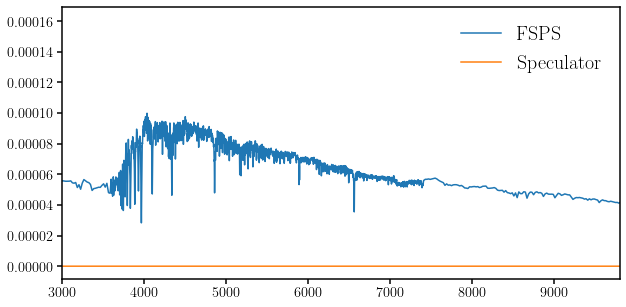

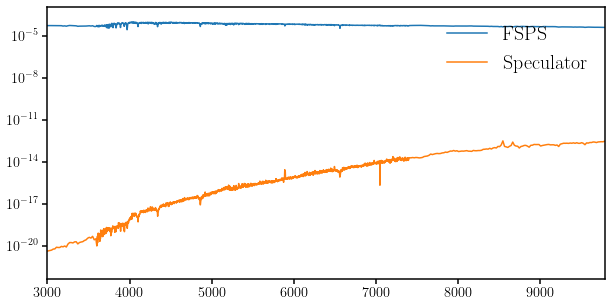

In [6]:
theta = np.array([
    0.25, # SFH basis coefficient 1
    0.25, # SFH basis coefficient 2
    0.25, # SFH basis coefficient 3
    0.25, # SFH basis coefficient 4
    3.66e-03, # ZH basis coefficient 1
    3.66e-03, # ZH basis coefficient 2
    13.7, # tage z=0
    0.])  # no dust


w, lum_fsps = FSPS_lumSSP(theta)
lum_speculator = emulator(theta)

fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(w, lum_fsps, label='FSPS')
sub.plot(wave, lum_speculator, label='Speculator')
sub.set_xlim(3e3, 9800.)
sub.legend(loc='upper right', fontsize=20)

fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(w, lum_fsps, label='FSPS')
sub.plot(wave, lum_speculator, label='Speculator')
sub.set_xlim(3e3, 9800.)
sub.set_yscale('log')
sub.legend(loc='upper right', fontsize=20)

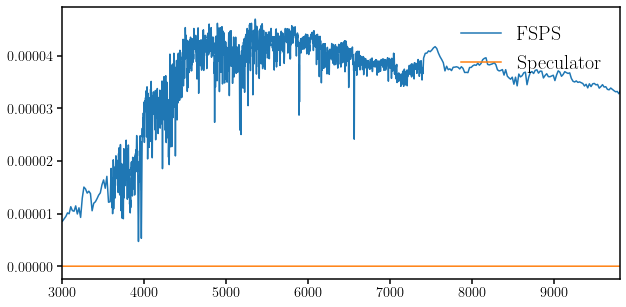

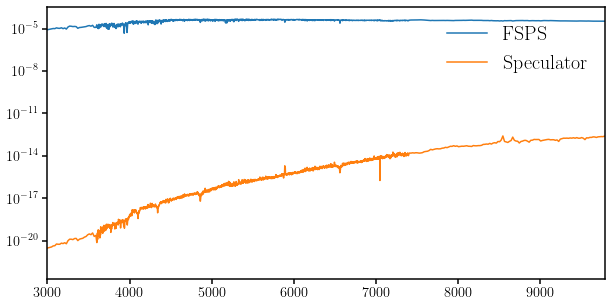

In [7]:
theta = np.array([
    1., # SFH basis coefficient 1
    0., # SFH basis coefficient 2
    0., # SFH basis coefficient 3
    0., # SFH basis coefficient 4
    3.66e-03, # ZH basis coefficient 1
    3.66e-03, # ZH basis coefficient 2
    13.7, # tage z=0
    0.])  # no dust

w, lum_fsps = FSPS_lumSSP(theta)
lum_speculator = emulator(theta)

fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(w, lum_fsps, label='FSPS')
sub.plot(wave, lum_speculator, label='Speculator')
sub.set_xlim(3e3, 9800.)
sub.legend(loc='upper right', fontsize=20)

fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(w, lum_fsps, label='FSPS')
sub.plot(wave, lum_speculator, label='Speculator')
sub.set_xlim(3e3, 9800.)
sub.set_yscale('log')
sub.legend(loc='upper right', fontsize=20)